# Setup data by stage

In [1]:
# dependencies
from os.path import isdir
from pathlib import Path
import re
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# support methods
def getfiles(arg, fext):
    assert isdir(arg)
    return [path for path in Path(arg).rglob(f'*.{fext}')]


def readtext(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()
    return lines

In [3]:
# main
pdfs = getfiles(arg="../../scrape/output/pdfs", fext='pdf')
pdfs_ref = pd.read_parquet("../../scrape/output/reference-table.parquet")
assert len(pdfs) >= 197
assert pdfs_ref.shape[0] >= 190
texts = getfiles(arg="../../pdf2text/output/txt-test/", fext='txt')
texts_ref = pd.read_parquet("../../pdf2text/output/reference-table.parquet")
assert len(texts) >= 197
assert texts_ref.shape[0] >= 190
segments = getfiles(arg="../../segment/output/each", fext='parquet')
segments_ref = pd.read_parquet("../../segment/output/reference-table.parquet")
assert not segments_ref.allegation_text.isna().any()
filtered = [path for path in getfiles(arg="../../filter/output", fext='parquet')
            if 'complaints' not in path.name]
filtered_ref = pd.read_parquet("../../filter/output/complaints.parquet")

# TODO finish debugging
cleaned = pd.read_parquet("../../clean/output/complaints.parquet")
indicated = pd.read_parquet("../../indicate/output/complaints.parquet")
complaints = pd.read_parquet("../../export/output/complaints.parquet")
allegations = complaints.dropna(subset=['allegations', 'findings_of_fact'])

dpa = complaints.copy()
working = dpa.loc[dpa.time_to_complete > pd.Timedelta(0)].copy()

# Preview

### review excluded PDFs


In [4]:
excluded = [str(pdf).replace('../../scrape/', '') for pdf in pdfs
          if str(pdf).replace('../../scrape/', '') not in pdfs_ref.pdf_file.values]
excluded

['output/pdfs/DPA_03_21_openness.pdf',
 'output/pdfs/DPA_05_21_openness.pdf',
 'output/pdfs/DPA_07_21_openness.pdf',
 'output/pdfs/DPA_02_21_openness.pdf.pdf',
 'output/pdfs/DPA_06_21_openness.pdf',
 'output/pdfs/DPA_01_21_openness.pdf']


##### Check for duplicate file:
- [ ] 'DPA_03_21_openness.pdf': Yes, '2021-07-DPA_03_21_openness'
- [ ] 'DPA_05_21_openness.pdf': Yes, '2021-08-DPA_05_21_openness_0'
- [ ] 'DPA_07_21_openness.pdf': Yes, '2021-08-DPA_07_21_openness'
- [ ] 'DPA_02_21_openness.pdf.pdf': Not checked
- [ ] 'DPA_06_21_openness.pdf': Not checked
- [ ] 'DPA_01_21_openness.pdf': Not checked

IIRC, there are two periods that could explain a few delayed or reposted reports:
1. transition from OCC to DPA
2. transition from old website to new one

I haven't confirmed either of those theories, but these file pairs match on first page contents and file size and this is enough for me to not worry about losing reports.

### review lost dates

In [5]:
filtered_ref.loc[(filtered_ref.date_complained.isna()) | (filtered_ref.date_completed.isna())].complaint_meta.values

array(['DATE OF COMPLAINT             01/04/18    DATE OF COMPLETION: 04/11/18                PAGE# 1 of 2 DATE OF COMPLAINT         01/04/18    DATE OF COMPLETION: 04/11/18        PAGE# 2 of 2'],
      dtype=object)

### segmenting reports

In [6]:
segments_ref.shape[0]

31492

In [7]:
segments_ref.sample().T

,24660
pdf_url,https://wayback.archive-it.org/org-571/2023012...
pdf_file,output/pdfs/occ-OCC_09_07_openness.pdf
fileid,8ba3709b
complaint_no,7
complaint_meta,DATE OF COMPLAINT: 04/25/07 DATE OF COMPLETION...
allegation_no,5
allegation_text,SUMMARY OF ALLEGATION #7: The officer caused p...
allegation_start_page,10
txt_file,../pdf2text/output/txt-test/occ-OCC_09_07_open...
blank_allegation,False


### extracting fields from segments

In [8]:
filtered_ref.shape[0]

31492

In [9]:
filtered_ref.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31492 entries, 0 to 31491
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   pdf_url                31492 non-null  object
 1   pdf_file               31492 non-null  object
 2   fileid                 31492 non-null  object
 3   complaint_no           31492 non-null  int64 
 4   complaint_meta         31492 non-null  object
 5   allegation_no          31492 non-null  int64 
 6   allegation_text        31492 non-null  object
 7   allegation_start_page  31492 non-null  int64 
 8   txt_file               31492 non-null  object
 9   blank_allegation       31492 non-null  bool  
 10  outside_jurisdiction   31492 non-null  bool  
 11  allegation_id          31492 non-null  object
 12  date_complained        31491 non-null  object
 13  date_completed         31492 non-null  object
 14  mediation_status       961 non-null    object
 15  mediated           

In [10]:
filtered_ref.sample().T

,23487
pdf_url,https://wayback.archive-it.org/org-571/2023012...
pdf_file,output/pdfs/occ-OCC_01_05_openness.pdf
fileid,4f77797d
complaint_no,21
complaint_meta,DATE OF COMPLAINT: 06/28/04 DATE...
allegation_no,1
allegation_text,SUMMARY OF ALLEGATION #1: The officer failed t...
allegation_start_page,40
txt_file,../pdf2text/output/txt-test/occ-OCC_01_05_open...
blank_allegation,False


### cleaning data

In [11]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31492 entries, 0 to 31491
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   pdf_url                31492 non-null  object        
 1   pdf_file               31492 non-null  object        
 2   fileid                 31492 non-null  object        
 3   complaint_no           31492 non-null  int64         
 4   complaint_meta         31492 non-null  object        
 5   allegation_no          31492 non-null  int64         
 6   allegation_text        31492 non-null  object        
 7   allegation_start_page  31492 non-null  int64         
 8   txt_file               31492 non-null  object        
 9   blank_allegation       31492 non-null  bool          
 10  outside_jurisdiction   31492 non-null  bool          
 11  allegation_id          31492 non-null  object        
 12  date_complained_text   31491 non-null  object        
 13  d

In [12]:
cleaned.sample().T

,21023
pdf_url,https://sf.gov/sites/default/files/2022-04/DPA...
pdf_file,output/pdfs/2022-04-DPA_01_22_openness_0.pdf
fileid,1e7c0bab
complaint_no,17
complaint_meta,DATE OF COMPLAINT: 02/03/19 DA...
allegation_no,2
allegation_text,SUMMARY OF ALLEGATIONS #3-6: The officers beha...
allegation_start_page,36
txt_file,../pdf2text/output/txt-test/2022-04-DPA_01_22_...
blank_allegation,False


### setting up indicators

In [13]:
indicated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31492 entries, 0 to 31491
Data columns (total 71 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   pdf_url                    31492 non-null  object         
 1   pdf_file                   31492 non-null  object         
 2   fileid                     31492 non-null  object         
 3   complaint_no               31492 non-null  int64          
 4   complaint_meta             31492 non-null  object         
 5   allegation_no              31492 non-null  int64          
 6   allegation_text            31492 non-null  object         
 7   allegation_start_page      31492 non-null  int64          
 8   txt_file                   31492 non-null  object         
 9   blank_allegation           31492 non-null  bool           
 10  outside_jurisdiction       31492 non-null  bool           
 11  allegation_id              31492 non-null  object     

In [14]:
indicated.sample().T

,17949
pdf_url,https://wayback.archive-it.org/org-571/2023012...
pdf_file,output/pdfs/occ-OCC_06_09_openness.pdf
fileid,98d679a2
complaint_no,98
complaint_meta,DATE OF COMPLAINT: 02/09/09 DATE OF COMPLETION...
...,...
inapp_action,False
malignant_action,False
failed_reqmt,True
time_to_complete,131 days 00:00:00


### final datasets

In [15]:
complaints.sample().T

,12362
pdf_url,https://wayback.archive-it.org/org-571/2023012...
pdf_file,output/pdfs/occ-OCC_11_07_openness.pdf
fileid,adca54e5
complaint_no,33
complaint_meta,DATE OF COMPLAINT: 01/26/07 DATE OF COMPLETION...
...,...
inapp_action,False
malignant_action,False
failed_reqmt,True
time_to_complete,293 days 00:00:00


In [16]:
allegations.sample()

,pdf_url,pdf_file,fileid,complaint_no,complaint_meta,allegation_no,allegation_text,allegation_start_page,txt_file,blank_allegation,...,arrest_wo_cause,display_weapon,unnec_force,dishonesty,bias,inapp_action,malignant_action,failed_reqmt,time_to_complete,ttc_group
23939,https://wayback.archive-it.org/org-571/2023012...,output/pdfs/occ-OCC_01_09_openness.pdf,85d0a954,75,DATE OF COMPLAINT: 03/04/08 DATE OF COMPLETION...,1,SUMMARY OF ALLEGATION #1: The officer arrested...,113,../pdf2text/output/txt-test/occ-OCC_01_09_open...,False,...,True,False,False,False,False,False,False,False,333 days,6 months to 1 year


# disclaimer
### things still in progress

There are data entry, parsing, and processing errors in the Datetime data that are still being worked out. Much of this has been recovered but where `time_to_complete` is referenced, it will be from the subset of data that has a logical `time_to_complete` value (ie. not negative).

In [17]:
dpa.time_to_complete.describe()

count                          28946
mean     256 days 01:57:24.289366408
std      233 days 05:39:29.956000140
min             -3135 days +00:00:00
25%                115 days 00:00:00
50%                243 days 00:00:00
75%                333 days 00:00:00
max               2805 days 00:00:00
Name: time_to_complete, dtype: object

In [18]:
working.time_to_complete.describe()

count                          28439
mean     261 days 12:52:59.352297904
std      228 days 15:35:24.568738260
min                  1 days 00:00:00
25%                119 days 00:00:00
50%                250 days 00:00:00
75%                333 days 00:00:00
max               2805 days 00:00:00
Name: time_to_complete, dtype: object

In [19]:
n_dropped = dpa.shape[0] - working.shape[0]
prop_dropped = round(n_dropped/dpa.shape[0], 3)
f"{n_dropped} rows or {prop_dropped*100:.1f}% of the data have an invalid `time_to_close`"

'593 rows or 2.0% of the data have an invalid `time_to_close`'

#### how many allegations are missing datetime info?

In [20]:
dpa.loc[dpa.year_complained.isna(), ['date_complained', 'year_complained']].shape[0]

82

In [21]:
dpa.loc[dpa.year_completed.isna(), ['date_completed', 'year_completed']].shape[0]

0

In [22]:
# report info for allegations missing date complained
# this is likely due to an extraction error we should be able to fix
# dpa.loc[dpa.year_complained.isna(), ['pdf_file', 'date_complained', 'complaint_meta']]

# about the collection

#### how many report files have been scraped?

In [23]:
len(dpa.fileid.unique())

191

#### how many complaints are represented in the collection?

In [24]:
len(dpa.complaint_id.unique())

11380

#### what is the timeline of complaints in the reports?

In [25]:
dpa.date_complained.describe()

count                            28950
mean     2012-05-12 19:38:42.652849664
min                2004-01-26 00:00:00
25%                2007-01-24 00:00:00
50%                2009-04-15 00:00:00
75%                2018-01-19 00:00:00
max                2024-09-03 00:00:00
Name: date_complained, dtype: object

#### how many allegations are represented in the collection?

In [26]:
len(dpa.allegation_id.unique())

29032

#### is the data 1 row per allegation?

In [27]:
dpa.shape[0] == len(dpa.allegation_id.unique())

True

#### how many complaints are in the average report?

In [28]:
dpa[['fileid', 'complaint_no']].groupby('fileid').complaint_no.max().mean().astype(int)

np.int64(65)

#### how many allegations are in the average complaint?

In [29]:
dpa[['complaint_id', 'allegation_no']].groupby('complaint_id').allegation_no.max().mean().astype(int)

np.int64(2)

# about the timeline

#### how many complaints are received over time?

<Axes: xlabel='year_complained'>

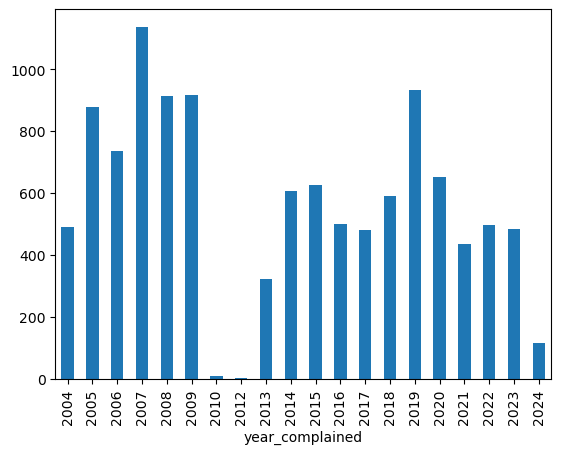

In [30]:
yearly_compls = dpa.loc[dpa.year_complained.notna(), ['year_complained', 'complaint_id']]
yearly_compls.year_complained = yearly_compls.year_complained.astype(int)
yearly_compls.groupby('year_complained').complaint_id.apply(
    lambda x: len(x.unique())).plot(kind='bar')

#### how many allegations are received over time?

<Axes: xlabel='year_complained'>

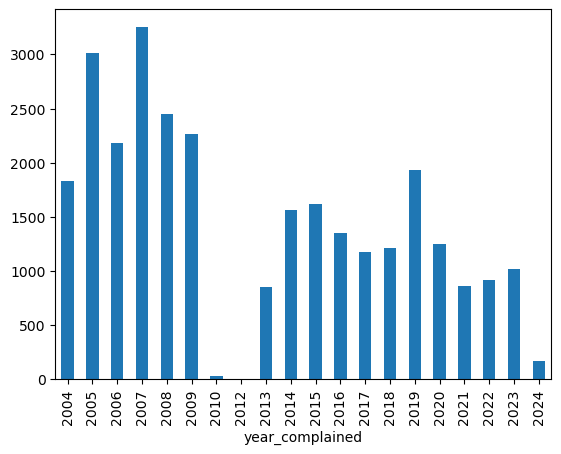

In [31]:
yearly_allegs = dpa.loc[dpa.year_complained.notna(), ['year_complained', 'allegation_id']]
yearly_allegs.year_complained = yearly_allegs.year_complained.astype(int)
yearly_allegs.groupby('year_complained').allegation_id.apply(
    lambda x: len(x.unique())).plot(kind='bar')

#### how long is the average investigation into a complaint?
- measured in days between `date_complained` and `date_completed`
- only includes allegations/rows with a non-negative `time_to_complete`
- organized by the `year_complained`

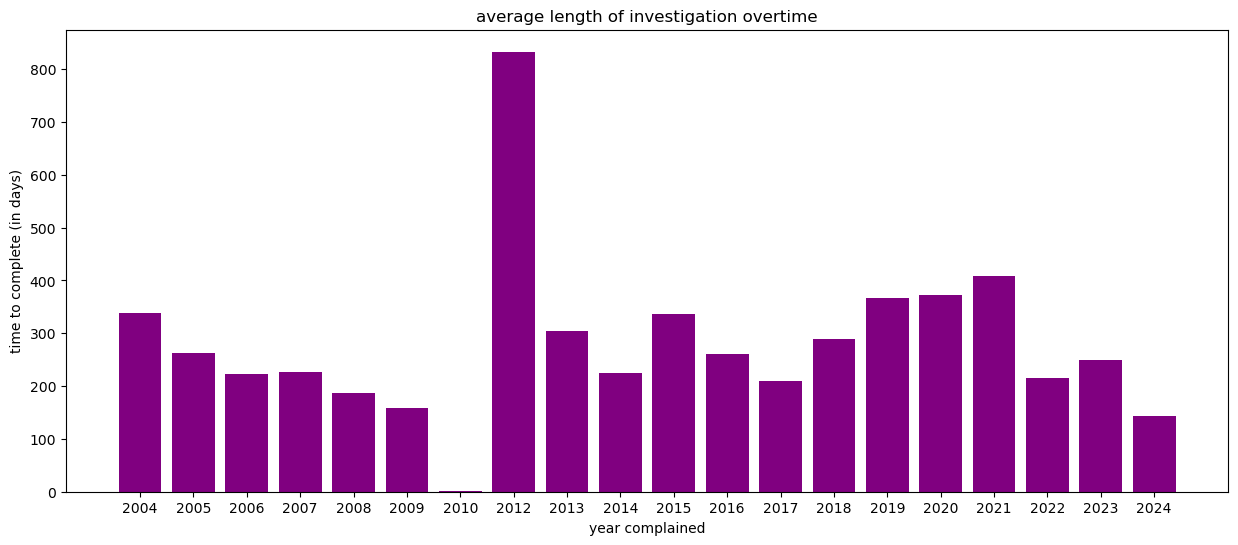

In [32]:
ttc_vc = working[['year_complained', 'time_to_complete']].groupby('year_complained').mean().sort_index().reset_index()
x = ttc_vc.year_complained.astype(int).astype(str).values
y = ttc_vc.time_to_complete.dt.days.values

fig= plt.figure(figsize=(15,6))
plt.title("average length of investigation overtime")
plt.xlabel("year complained")
plt.ylabel("time to complete (in days)")
plt.bar(x,y, label='', color='purple')
plt.show()

## about `sustained` or `mediated` allegations

#### how many allegations were sustained?

In [33]:
dpa.sustained.value_counts()

sustained
False    27512
True      1520
Name: count, dtype: int64

#### how many allegations were mediated?

In [34]:
dpa.mediated.value_counts()

mediated
False    27983
True      1049
Name: count, dtype: int64

#### are any allegations both mediated and sustained? or are these mutually exclusive?

In [35]:
(dpa.sustained & dpa.mediated).any()

np.False_

#### what are the original `finding` codes for `sustained` allegations?

In [36]:
dpa.loc[dpa.sustained == True, 'finding_original'].value_counts()

finding_original
S                   1128
PF                   170
TF                   107
IC(S)                 41
IC                    30
IC (Sustained)        13
SF                     8
SUS                    7
IC (SUSTAINED)         4
SUST                   4
Sustained              3
Improper Conduct       2
Policy Failure         2
ICS                    1
Name: count, dtype: int64

#### what are top 5 the original `conduct_category` codes for `sustained` allegations?

In [37]:
dpa.loc[dpa.sustained == True, 'conduct_category'].value_counts().head()

conduct_category
Neglect of Duty          831
Unwarranted Action       357
Unknown category: CRD    198
Unnecessary Force         55
Discourtesy               38
Name: count, dtype: int64

#### what are the top 5 original `conduct_category` codes for `mediated` allegations?

In [38]:
dpa.loc[dpa.mediated == True, 'conduct_category'].value_counts().head()

conduct_category
Neglect of Duty                  395
Unknown category: CRD            324
Unwarranted Action               222
Conduct Unbecoming an Officer     65
Discourtesy                       24
Name: count, dtype: int64

#### what are the top 5 original `finding` codes for allegations not `sustained` or `mediated`?

In [39]:
dpa.loc[~(dpa.sustained | dpa.mediated), 'finding'].value_counts().head()

finding
NS                10081
Proper Conduct     6506
NF                 2404
Unfounded          2390
NF/W                890
Name: count, dtype: int64

#### what are the rates of `mediated` and `sustained` allegations over time compared to other outcomes?

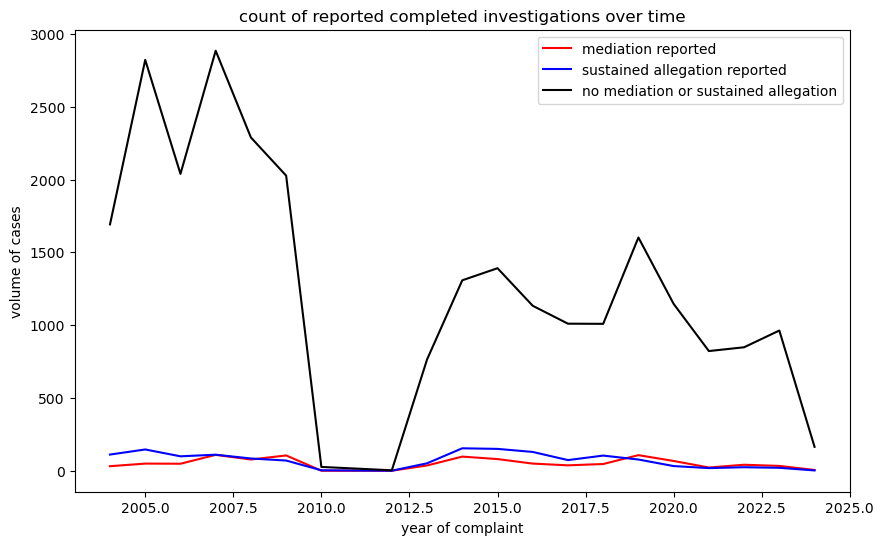

In [40]:
test = working[['year_complained', 'mediated', 'sustained']
    ].groupby('year_complained').value_counts().to_frame().reset_index()
x = sorted(test.year_complained.unique())
y = {str(int(year)):
     test.loc[(test.year_complained == year) & (test.mediated),
     'count'].sum() for year in sorted(test.year_complained.unique())
    }.values()
y2 = {str(int(year)):
     test.loc[(test.year_complained == year) & (test.sustained),
     'count'].sum() for year in sorted(test.year_complained.unique())
    }.values()
y3 = {str(int(year)):
     test.loc[(test.year_complained == year) & (~(test.mediated | test.sustained)),
     'count'].sum() for year in sorted(test.year_complained.unique())
    }.values()

fig= plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(x, y, label='mediation reported', color='red')
plt.plot(x, y2, label='sustained allegation reported', color='blue')
plt.plot(x, y3, label='no mediation or sustained allegation', color='black')
plt.title("count of reported completed investigations over time")
plt.xlabel("year of complaint")
plt.ylabel("volume of cases")
ax.legend(loc='upper right')
plt.show()

# about the allegations

#### what are the top 5 types of allegations by `conduct_category`?

In [41]:
dpa.conduct_category.value_counts().head()

conduct_category
Neglect of Duty                  8028
Unwarranted Action               7697
Unknown category: CRD            5397
Unnecessary Force                2211
Conduct Unbecoming an Officer    1686
Name: count, dtype: int64

#### what do the indicators derived from the SUMMARY OF ALLEGATION data say about the allegation categories?

In [42]:
dpa[[
    'action_wo_cause',
    'entry_wo_cause', 'search_wo_cause', 'towed_wo_cause',
    'tookproperty_wo_cause', 'cite_wo_cause', 'detain_wo_cause',
    'arrest_wo_cause', 'display_weapon', 'unnec_force', 'dishonesty',
    'bias', 'inapp_action', 'malignant_action', 'failed_reqmt',
]].sum().sort_values(ascending=False)

failed_reqmt             7551
inapp_action             6352
action_wo_cause          5863
unnec_force              2127
detain_wo_cause          1781
malignant_action         1335
arrest_wo_cause          1191
cite_wo_cause            1121
bias                      783
search_wo_cause           724
dishonesty                260
entry_wo_cause            241
towed_wo_cause            217
tookproperty_wo_cause     152
display_weapon             55
dtype: int64

## how do the indicators compare to the DPA categories?

#### what kind of allegations are considered `Unwarranted Action` by the DPA?

In [43]:
dpa.loc[dpa.conduct_category == 'Unwarranted Action', 'allegations'].value_counts().head()

allegations
The officer issued a citation without cause.                    544
The officer detained the complainant without justification.     526
The officer arrested the complainant without cause.             455
The officers detained the complainant without justification.    359
The officers arrested the complainant without cause.            264
Name: count, dtype: int64

#### what kind of allegations are considered `action_wo_cause`?

In [44]:
dpa.loc[dpa.action_wo_cause, 'allegations'].value_counts().head()

allegations
The officer issued a citation without cause.                    551
The officer detained the complainant without justification.     530
The officer arrested the complainant without cause.             457
The officers detained the complainant without justification.    359
The officers arrested the complainant without cause.            265
Name: count, dtype: int64

#### what kind of allegations are considered `CRD` by the DPA?

In [45]:
dpa.loc[dpa.conduct_category == 'CRD', 'allegations'].value_counts().head(10)

Series([], Name: count, dtype: int64)

```{note}
1. `Neglect of Duty` is similar in context and frequency to `failed_reqmt`. Our count is a bit lower likely due to a combination of:
    - the coarse nature of the regex
    - messy or noisy extractions that could be recovered with different processing
    - difference in what is counted as 'Neglect of Duty' compared to my interpretation of certain allegations
2. `Unwarranted Action` is similar in context and frequency to `action_wo_cause`.
    - It looks like we might have a gap in definitional coverage for these two, what is considered unwarranted action that I didn't pick up as an action without cause?
    - Note: `wo_cause` represents the identification of some variation of "without cause", "without justification", etc. The DPA category may include allegations that were more nuanced / less explicit than that in the content of the allegation.
3. It's unclear to me what `CRD` stands for as a category, I suspect the "C" is "Conduct", but I don't see "RD" in the codes discussed in public reporting manuals. The allegations seem to include what I count as inappropriate or malignant activity, dishonesty, and more? Unclear how this is distinct from `Conduct Unbecoming`.
    - older source: [sfpd-dgo-204-citizen-complaints-against-officers.pdf
](https://www.sanfranciscopolice.org/sites/default/files/2019-06/sfpd-dgo-204-citizen-complaints-against-officers.pdf)
    - recent source: [SFPDNotice.21026.20210329.pdf
](https://www.sanfranciscopolice.org/sites/default/files/2021-03/SFPDNotice.21026.20210329.pdf)
4. `Unnecessary Force` is very similar in context and frequency to `unnec_force`. Our count is a bit lower likely due to the same reason that (1) is off.
5. Allegations that might be labeled `Conduct Unbecoming` by the DPA are spread out into `inapp_action`, `malignant_action`, `bias`, and `dishonesty`.
6. `Discourtesy`, `Racial Slur`, and `Sexual Slur` are considered `malignant_action`.
```

#### what kind of allegations are considered `inapp_action`?
- or "inappropriate action"

In [46]:
dpa.loc[dpa.inapp_action, 'allegations'].value_counts().head()

allegations
The officer behaved or spoke inappropriately.                             595
The officer behaved inappropriately.                                      440
The officer behaved inappropriately and made inappropriate\n comments.    381
The officer used profanity.                                               341
The officer made inappropriate comments.                                  303
Name: count, dtype: int64

#### what kind of allegations are considered `malignant_action`?

In [47]:
dpa.loc[dpa.malignant_action, 'allegations'].value_counts().head()

allegations
The officer threatened the complainant.                                       122
The officer displayed threatening, intimidating, or harassing\n behavior.     121
The officer harassed the complainant.                                          98
The officers displayed threatening, intimidating, or harassing\n behavior.     33
The officer engaged in retaliatory behavior.                                   33
Name: count, dtype: int64

#### what kind of allegations are considered `dishonesty` or `bias`?

In [48]:
dpa.loc[dpa.dishonesty, 'allegations'].value_counts().head()

allegations
The officer misrepresented the truth.                       175
The officers misrepresented the truth.                       38
The officer filed false charges against the complainant.     15
The officer filed false charges.                              8
The officer misrepresented the truth                          3
Name: count, dtype: int64

In [49]:
dpa.loc[dpa.bias, 'allegations'].value_counts().head()

allegations
The officer knowingly engaged in biased policing or\n discrimination.     102
The officer engaged in biased policing due to race.                        78
The officer engaged in selective enforcement.                              65
The officer engaged in biased policing based on race.                      48
The officers knowingly engaged in biased policing or\n discrimination.     44
Name: count, dtype: int64

# `liability`

In [50]:
dpa.loc[dpa.findings_of_fact.str.contains('liability', na=False)].shape[0]

35